In [2]:
import numpy as np
import scipy.stats # for creating a simple dataset 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [62]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
import tensorflow.keras.layers as L

In [57]:
def create_twomoon_dataset(n, p):
    relevant, y = make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
    print(y.shape)
    noise_vector = scipy.stats.norm.rvs(loc=0.0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    print(data.shape)
    return data, y

In [58]:
X, Y = create_twomoon_dataset(10000, 20)

(10000,)
(10000, 20)


In [50]:
X.shape, Y.shape

((10000, 20), (10000,))

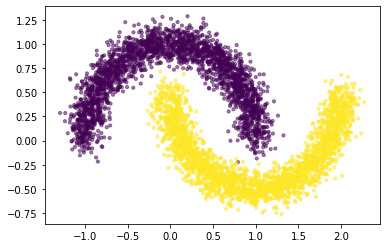

In [266]:
f1, f2 = X_train[:, 0], X_train[:, 1]
plt.scatter(x=f1, y=f2, c=y_train, s=10, alpha=0.5)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7)

In [70]:
X_train.shape, X_test.shape, X_valid.shape

((4900, 20), (3000, 20), (2100, 20))

In [250]:
class FeatureSelector(tf.keras.layers.Layer):
    def __init__(self, sigma=0.5, penalty=0.5):
        super(FeatureSelector, self).__init__()
        self.sigma = sigma
        self.penalty = penalty

    def build(self, input_shape):
        self.num_outputs = int(input_shape[-1])
        self.mu = self.add_weight(
            name = "mu",
            shape = [self.num_outputs,],
            regularizer = self.cdf_regularizer,
            initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True
        )

    def call(self, inputs, training):
        z = self.mu
        if training:
            z = self.mu + self.sigma * tf.random.normal(shape=[self.num_outputs, ])
        z_gate = self.hard_clip(z)
        out = tf.math.multiply(inputs, z_gate)
        return out
    
    def hard_clip(self, inputs):
        return tf.clip_by_value(inputs+0.5, clip_value_min=0., clip_value_max=1.)
    
    def cdf_regularizer(self, weights):
        x = (weights + 0.5)/self.sigma
        cdf = 0.5 * (1. + tf.math.erf(x / tf.math.sqrt(2.)))
        return self.penalty * tf.reduce_mean(cdf)
    
    def get_gates(self):
        return self.hard_clip(self.mu)

In [269]:
metrics = [ 
      tf.keras.metrics.AUC(name='auc'), 'accuracy'
]

def get_model():
    inp = L.Input(shape=(X_train.shape[1], ), name='input')
    bn = L.BatchNormalization(center=False, scale=False, name='batch_norm')(inp)
    fs = FeatureSelector()(bn)
    dense1 = L.Dense(60, activation='relu', name='dense1')(fs)
    dropout1 = L.Dropout(rate=0.3, name='dropout1')(dense1)
    dense2 = L.Dense(20, activation='relu', name='dense2')(dropout1)
    out = L.Dense(1, activation='sigmoid', name='output')(dense2)

    model = Model(inputs=inp, outputs=out)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    print(model.summary())
    return model

In [270]:
model = get_model()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
batch_norm (BatchNormalizati (None, 20)                40        
_________________________________________________________________
feature_selector_26 (Feature (None, 20)                20        
_________________________________________________________________
dense1 (Dense)               (None, 60)                1260      
_________________________________________________________________
dropout1 (Dropout)           (None, 60)                0         
_________________________________________________________________
dense2 (Dense)               (None, 20)                1220      
_________________________________________________________________
output (Dense)               (None, 1)                 21 

In [271]:
model.fit(
    x = X_train,
    y = y_train,
    epochs=2500,
    batch_size = X_train.shape[0],
    validation_data = (X_test, y_test),
    verbose=0,
    shuffle=True
)

In [274]:
fs = model.get_layer(index=2)

In [275]:
fs.mu

<tf.Variable 'feature_selector_26/mu:0' shape=(20,) dtype=float32, numpy=
array([ 1.0318954,  0.8899543, -1.5953795, -1.596608 , -1.5918634,
       -1.592357 , -1.5905213, -1.5974768, -1.5923434, -1.5958047,
       -1.5912375, -1.5895077, -1.5931133, -1.5982299, -1.5903326,
       -1.592992 , -1.5926428, -1.5899537, -1.5957912, -1.585711 ],
      dtype=float32)>

In [276]:
fs.get_gates()

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>